# Bibliotecas

In [440]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Setup

In [441]:
sns.set()

# Variáveis de ambiente

In [442]:
DATA_PATH = '../content/'

In [443]:
os.listdir('../content')

['.config', 'dengue-dataset.csv', 'sample_data']

# Carregamento dos dados

In [444]:
raw_df = pd.read_csv(os.path.join(DATA_PATH, 'dengue-dataset.csv'))
df.head()

,casos-confirmados,chuva,temperatura-media,temperatura-mininima,temperatura-maxima,mes,ano,dia
0,237,179.2,25.7,20.2,28.1,1,1998,1
1,331,226.3,25.1,20.0,28.0,2,1998,1
2,562,149.1,24.8,22.4,27.2,3,1998,1
3,187,46.4,22.7,18.1,26.0,4,1998,1
4,32,88.3,19.2,15.7,22.9,5,1998,1




# Função de feature engineering

In [445]:
def featuring_engineering(df):
  df['data'] = pd.to_datetime(df['data'])
  df['mes'] = df['data'].dt.month
  df['ano'] = df['data'].dt.year
  df['dia'] = df['data'].dt.day
  df = df.drop(['data'], axis=1)
  return df


**Função print outliers**

A presença de outliers pode prejudicar a capacidade de generalização dos modelos. Para lidar com este problema, foi aplicada a técnica do z-score, que é uma medida estatística que expressa o quão longe um ponto de dados está da média de uma distribuição em termos de desvios padrão. No caso em questão, foi especificado o limiar = 3.

A função abaixo printa as linhas que contém outliers:

In [446]:
def print_outliers(df, threshold=3):
  # Z-score para cada valor em cada coluna
  z_scores = np.abs(stats.zscore(df))

  # limite para considerar um valor como outlier
  threshold = 3

  # verificação de outliers
  outlier_indices = np.where(z_scores > threshold)


  outliers = [(df.index[i], df.columns[j]) for i, j in zip(*outlier_indices)]

  print("Outliers:")
  for i, j in outliers:
      print(f"Valor {df.at[i, j]} na coluna {j} da linha {i} é um outlier.")



# Análise de dados exploratória

In [447]:
df.shape

(201, 8)

In [448]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 203
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   casos-confirmados     201 non-null    int64  
 1   chuva                 201 non-null    float64
 2   temperatura-media     201 non-null    float64
 3   temperatura-mininima  201 non-null    float64
 4   temperatura-maxima    201 non-null    float64
 5   mes                   201 non-null    int64  
 6   ano                   201 non-null    int64  
 7   dia                   201 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 14.1 KB


In [449]:
df.describe()

,casos-confirmados,chuva,temperatura-media,temperatura-mininima,temperatura-maxima,mes,ano,dia
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.0
mean,171.497512,117.512953,22.195522,17.671144,25.565174,6.537313,2005.880597,1.0
std,508.706822,95.094406,2.405729,3.346216,2.257118,3.471289,4.848265,0.0
min,0.000000,0.800000,16.400000,8.200000,19.100000,1.000000,1998.000000,1.0
25%,6.000000,46.400000,20.100000,15.000000,23.800000,4.000000,2002.000000,1.0
50%,17.000000,93.000000,22.700000,18.100000,26.200000,7.000000,2006.000000,1.0
75%,76.000000,176.500000,24.200000,20.400000,27.200000,10.000000,2010.000000,1.0
max,4207.000000,452.800000,27.200000,23.500000,30.100000,12.000000,2014.000000,1.0


Os dados estão num intervalo entre 1998 e 2014. Estão distribuídos de forma balanceada, exceto no ano de 2006.

Text(0.5, 1.0, 'Distribuição dos dados por ano')

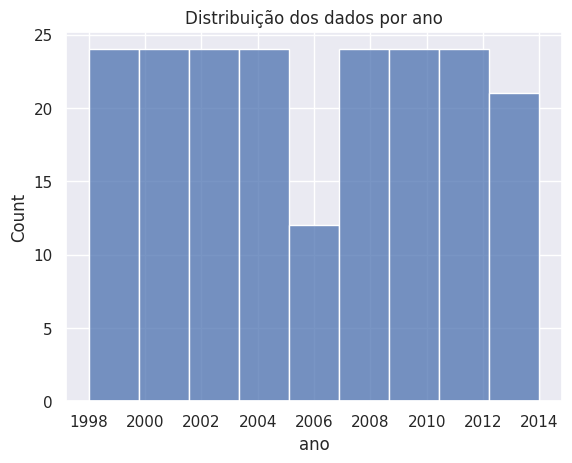

In [450]:
sns.histplot(data=df, x='ano')
plt.title('Distribuição dos dados por ano')

In [451]:
df = featuring_engineering(raw_df)

In [452]:
print_outliers(df)

Outliers:
Valor 7555 na coluna casos-confirmados da linha 194 é um outlier.
Valor 20428 na coluna casos-confirmados da linha 195 é um outlier.
Valor 10484 na coluna casos-confirmados da linha 196 é um outlier.


In [453]:
df = df[~df.index.isin([194, 195, 196])]

In [454]:
# Substituição de NaNs pela mediana em todas as colunas com NaNs
df = df.fillna(df.mean())

In [455]:
df.shape

(201, 8)

In [456]:
df.head()

,casos-confirmados,chuva,temperatura-media,temperatura-mininima,temperatura-maxima,mes,ano,dia
0,237,179.2,25.7,20.2,28.1,1,1998,1
1,331,226.3,25.1,20.0,28.0,2,1998,1
2,562,149.1,24.8,22.4,27.2,3,1998,1
3,187,46.4,22.7,18.1,26.0,4,1998,1
4,32,88.3,19.2,15.7,22.9,5,1998,1


In [457]:
X = df.drop('casos-confirmados', axis=1)
y = df['casos-confirmados']

# **Conjuntos de treino, validação e teste**

## **Conjunto de Treinamento (Training Set):**

O conjunto de treinamento é usado para alimentar o modelo de Machine Learning durante o processo de treinamento. Ele contém a maior parte dos dados com os quais o modelo aprende a fazer previsões. O objetivo é que o modelo capture os padrões, as relações e as características nos dados que permitirão fazer previsões precisas no futuro.

Os dados do conjunto de treinamento são usados para ajustar os parâmetros internos do modelo, com o objetivo de minimizar o erro entre as previsões do modelo e os valores reais.

O conjunto de treinamento é a base do modelo e é fundamental para seu desenvolvimento.

## **Conjunto de Validação (Validation Set):**

O conjunto de validação é usado principalmente para ajustar hiperparâmetros do modelo. Os hiperparâmetros são configurações que não são aprendidas pelo modelo durante o treinamento.

Após o treinamento com o conjunto de treinamento, o modelo é avaliado no conjunto de validação usando diferentes configurações de hiperparâmetros. Isso ajuda a selecionar as configurações que resultam no melhor desempenho em dados não vistos, sem usar o conjunto de teste para esse fim.

A separação do conjunto de validação ajuda a evitar o ajuste excessivo dos hiperparâmetros aos dados de teste, o que preserva a integridade da avaliação do modelo.

## **Conjunto de Teste (Testing Set)**

O conjunto de teste é reservado para avaliar o desempenho do modelo após o treinamento e o ajuste dos hipermarâmetros. Ele consiste em dados que o modelo "nunca viu" durante o treinamento. Isso é fundamental para verificar se o modelo é capaz de generalizar e fazer previsões precisas em dados novos e não vistos.

Os dados do conjunto de teste são usados para medir métricas de desempenho, como precisão, sensibilidade, especificidade ou erro médio quadrático, dependendo do tipo de problema (classificação, regressão etc.). No caso em questão, utilizado a métrica MAE. Essas métricas ajudam a avaliar quão bem o modelo está fazendo as previsões.

A divisão em conjunto de teste ajuda a identificar problemas como overfitting, onde o modelo se ajustou muito aos dados de treinamento, mas não consegue generalizar para novos dados.

In [458]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# **Normalização dos Dados e Data Leakage**

## Normalização dos Dados

A normalização dos dados é um processo no qual os valores das características (variáveis) em um conjunto de dados são transformados para que tenham uma escala uniforme. Isso geralmente envolve a reescala dos valores das características para que estejam dentro de um intervalo específico. No caso em questão, foi utiizado o StandardScale, uma técnica de normalização que ajusta os dados para que tenham média zero e desvio padrão igual a um.

A normalização é importante porque ajuda a garantir que os modelos de Machine Learning sejam treinados e funcionem corretamente. Ela contribui para o desempenho e a convergência dos algoritmos, evita o domínio de características com escalas maiores e melhora a interpretabilidade dos resultados.

## Data Leakage (Vazamento de Dados)

O data leakage, ou vazamento de dados, ocorre quando informações do conjunto de dados de teste ou validação são de alguma forma incluídas acidentalmente durante o treinamento do modelo. Isso é um erro crítico, pois viola a suposição fundamental de que os dados de teste e validação são independentes dos dados de treinamento.

# Importância de Normalizar Conjuntos de Dados Separadamente

A importância de normalizar conjuntos de dados separadamente está relacionada à prevenção do vazamento de dados. Quando todos os dados (treinamento, validação e teste) são normalizados usando as estatísticas (média e desvio padrão) calculadas a partir do **conjunto de treinamento**, é garantido que a mesma transformação seja aplicada de maneira consistente a todos os conjuntos. Isso é fundamental para evitar o vazamento de informações dos conjuntos de teste ou validação para o conjunto de treinamento.

Se a normalização todos os dados fosse realizada usando as estatísticas dos conjuntos de teste ou validação, haveria uma contaminação dos dados de treinamento com informações dos dados de teste ou validação, o que prejudicaria a validação e tornaria os resultados enganosos. Portanto, a normalização separada é crucial para manter a independência dos conjuntos de dados e garantir a confiabilidade dos resultados de Machine Learning.

In [459]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# **Feature Selection com a técnica RFE**

A seleção de características, ou Feature Selection, é um processo essencial na construção de modelos de Machine Learning. Ela envolve a escolha das características (variáveis) mais relevantes em um conjunto de dados para a tarefa de modelagem. Entre as diversas técnicas de seleção de características, uma das mais poderosas é a Recursive Feature Elimination (RFE), que é particularmente útil em contextos de Machine Learning.

## O que é RFE (Recursive Feature Elimination)?

A Recursive Feature Elimination (RFE) é uma técnica de seleção de características que opera de maneira recursiva para identificar as características mais importantes em um conjunto de dados. O processo funciona da seguinte maneira:

Um modelo de Machine Learning é treinado no conjunto de dados completo.
As características são classificadas de acordo com sua importância ou contribuição para o desempenho do modelo.

As características menos importantes são removidas do conjunto de dados.
O processo é repetido iterativamente até que o número desejado de características seja alcançado.

A RFE geralmente começa com todas as características e, em cada iteração, remove a característica menos importante, avaliando o desempenho do modelo. Esse processo é repetido até que o número especificado de características seja atingido. O modelo final é treinado apenas nas características selecionadas.

## Importância da Feature Selection com RFE em Machine Learning

A Feature Selection com RFE desempenha um papel fundamental em projetos de Machine Learning por várias razões:

Melhora a Generalização: Ao selecionar apenas as características mais importantes, a RFE ajuda a evitar o overfitting, que ocorre quando um modelo se ajusta excessivamente aos dados de treinamento e não generaliza bem para novos dados. Com menos características, o modelo pode capturar os padrões mais significativos.

Reduz a Dimensionalidade: Em conjuntos de dados com muitas características, a RFE permite reduzir a dimensionalidade, o que facilita a visualização e a interpretação dos resultados. A alta dimensionalidade pode aumentar a complexidade do modelo e dificultar o treinamento.

Economiza Recursos Computacionais: Ao usar apenas um subconjunto de características, a RFE reduz o esforço computacional necessário para treinar e avaliar o modelo. Isso é particularmente importante em conjuntos de dados grandes.

Aumenta a Interpretabilidade: Modelos com menos características são mais fáceis de interpretar. Isso é crucial em áreas como a medicina, onde a transparência e a interpretabilidade do modelo são essenciais.

Aprimora o Desempenho: A seleção de características com a RFE pode melhorar o desempenho do modelo, concentrando-se nas características mais relevantes para a tarefa.



In [460]:
# Seleção de Características (Feature Selection) com RFE
rf_reg = RandomForestRegressor(random_state=42)
rfe = RFE(rf_reg, n_features_to_select=3)
rfe.fit(X_train, y_train)
X_train_selected = rfe.transform(X_train)
X_val_selected = rfe.transform(X_val)
X_test_selected = rfe.transform(X_test)

**Support Vector Regressor (SVR):**

O Support Vector Regressor (SVR) é um algoritmo de aprendizado de máquina que pertence à família das Máquinas de Vetores de Suporte (SVM). O SVR é usado para problemas de regressão, onde o objetivo é prever valores numéricos. Ele opera encontrando uma função que melhor se ajusta aos dados de treinamento, ao mesmo tempo em que minimiza a margem de erro. O SVR é eficaz para lidar com dados não lineares, utilizando funções de kernel para mapear os dados em espaços de alta dimensão.

**Random Forest Regressor:**

O Random Forest Regressor é um modelo de aprendizado de máquina baseado na técnica de ensemble. Ele utiliza múltiplas árvores de decisão (daí o termo "floresta") para fazer previsões de regressão. Cada árvore individual é treinada em uma amostra aleatória dos dados e produz uma previsão. O resultado final do Random Forest Regressor é uma média ou uma combinação ponderada das previsões das árvores individuais. Essa abordagem reduz o overfitting e aumenta a precisão das previsões.

**Gradient Boosting Regressor:**

O Gradient Boosting Regressor é outro modelo de ensemble, mas funciona de maneira diferente do Random Forest. Ele cria uma sequência de árvores de decisão, onde cada árvore é treinada para corrigir os erros da árvore anterior. Essa abordagem é eficaz em melhorar o desempenho do modelo, pois foca em regiões do espaço de características onde o modelo atual está errado. O Gradient Boosting Regressor é especialmente útil para problemas de regressão com alta precisão.

**GridSearchCV:**

O GridSearchCV é uma técnica de otimização de hiperparâmetros que ajuda a encontrar a melhor combinação de hiperparâmetros para um modelo. Ele realiza uma pesquisa exaustiva em um espaço de hiperparâmetros definido, treinando e avaliando o modelo para cada combinação. Isso permite ajustar o modelo para obter o melhor desempenho possível.

**Ensemble de Modelos:**

Ensemble é uma técnica que combina vários modelos individuais para melhorar o desempenho e a robustez das previsões. Pode-se criar ensembles usando diferentes algoritmos de aprendizado de máquina. Um exemplo comum é o ensemble de modelos baseados em árvores, como Random Forest e Gradient Boosting. Nesse caso, os modelos individuais são árvores de decisão e são combinados para produzir previsões mais precisas e estáveis.

Ensemble de modelos é uma estratégia poderosa, pois aproveita a diversidade de modelos para superar as fraquezas individuais de cada um. Random Forest, por exemplo, usa múltiplas árvores de decisão para mitigar o overfitting. Gradient Boosting, por sua vez, foca em melhorar o desempenho do modelo ao criar uma sequência de árvores de decisão. O uso de GridSearchCV para otimizar os hiperparâmetros desses modelos em conjunto pode levar a resultados excepcionais, tornando o ensemble uma abordagem valiosa em problemas de regressão e classificação em Machine Learning.

In [461]:
# Treinamento dos modelos com busca de hiperparâmetros
svr_reg = SVR()
svr_param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1]
}
svr_reg = GridSearchCV(svr_reg, svr_param_grid, cv=5, scoring='neg_mean_squared_error')
svr_reg.fit(X_train_selected, y_train)

rf_reg = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}
rf_reg = GridSearchCV(rf_reg, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_reg.fit(X_train_selected, y_train)

gb_reg = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5]
}
gb_reg = GridSearchCV(gb_reg, gb_param_grid, cv=5, scoring='neg_mean_squared_error')
gb_reg.fit(X_train_selected, y_train)

# Criando o ensemble de modelos
ensemble = VotingRegressor(estimators=[
    ('svr', svr_reg.best_estimator_),
    ('rf', rf_reg.best_estimator_),
    ('gb', gb_reg.best_estimator_)
])

# Treinando o ensemble nos dados de treinamento
ensemble.fit(X_train_selected, y_train)

# Fazendo previsões nos dados de validação
ensemble_predictions_val = ensemble.predict(X_val_selected)
ensemble_mae_val = mean_absolute_error(y_val, ensemble_predictions_val)

# Fazendo previsões nos dados de teste
ensemble_predictions_test = ensemble.predict(X_test_selected)
ensemble_mae_test = mean_absolute_error(y_test, ensemble_predictions_test)


**O Erro Médio Absoluto (MAE) na Previsão do Número de Casos de Dengue**

O Erro Médio Absoluto (MAE) é uma métrica de avaliação amplamente usada em tarefas de previsão. Essa métrica desempenha um papel fundamental na avaliação da eficácia dos modelos de previsão e na medição de quão bem esses modelos se alinham com a realidade.

O MAE é uma medida direta da diferença entre as previsões feitas por um modelo e os valores reais observados. É calculado como a média dos valores absolutos dessas diferenças. O MAE tem várias vantagens que o tornam apropriado para prever o número de casos de dengue e para outras aplicações de previsão:

**1. Interpretação Intuitiva:** O MAE fornece uma avaliação fácil de interpretar. Ele expressa a média dos erros de previsão em termos da mesma unidade dos dados, no caso, o número de casos de dengue. Portanto, uma diminuição no MAE indica que o modelo está fazendo previsões mais precisas em relação à realidade.

**2. Sensibilidade a Erros de Previsão:** O MAE considera erros de previsão em termos de sua magnitude absoluta. Isso significa que ele é sensível a todos os erros, independentemente de serem positivos (previsões superestimadas) ou negativos (previsões subestimadas). Ao usar o MAE, não ignoramos erros que podem ter impactos significativos na saúde pública.

**3. Ênfase na Precisão:** Em cenários como a previsão de casos de dengue, a precisão é crucial. Erros de previsão podem levar a respostas ineficazes às epidemias e ao uso inadequado de recursos. O MAE coloca um foco direto na precisão das previsões, ajudando a identificar o desempenho do modelo.

**4. Avaliação Justa de Modelos:** O MAE é uma métrica justa e amplamente aceita para avaliar o desempenho de modelos de previsão. Ele fornece uma base sólida para comparar diferentes abordagens de modelagem e para determinar quais modelos são mais adequados para a tarefa de previsão de casos de dengue.

In [462]:
# Resultados nos dados de validação
print("Resultados no conjunto de validação do Ensemble:")
print(f"Ensemble - MAE nos dados de validação: {ensemble_mae_val}")

# Resultados nos dados de teste
print("Resultados no conjunto de teste do Ensemble:")
print(f"Ensemble - MAE nos dados de teste: {ensemble_mae_test}")

Resultados no conjunto de validação do Ensemble:
Ensemble - MAE nos dados de validação: 170.64749611349004
Resultados no conjunto de teste do Ensemble:
Ensemble - MAE nos dados de teste: 344.3007738321123


## **Avaliação dos resultados**

**Conjunto de Validação:** O MAE de 170.65 nos dados de validação indica que o modelo Ensemble está produzindo previsões com um erro médio absoluto de aproximadamente 170,65 unidades (casos de dengue) em relação aos valores reais.

**Conjunto de Teste:** O MAE de 344.30 nos dados de teste é mais elevado do que o observado no conjunto de validação. Isso indica que o modelo Ensemble pode não estar generalizando tão bem para dados não vistos, o que é uma preocupação. Um MAE mais alto nos dados de teste sugere que as previsões do modelo estão mais distantes dos valores reais e que o modelo pode estar sofrendo de overfitting (ajuste excessivo) aos dados de treinamento.

# **Incorporando a Média Móvel para Melhorar a Previsão**

Para aprimorar o desempenho do modelo na previsão de casos de dengue, foi incorporada uma nova variável, que é a "média móvel de 7 dias" (ou "média móvel de 1 semana"). A média móvel é uma técnica estatística frequentemente utilizada em análises de séries temporais e é particularmente útil para suavizar flutuações de curto prazo e identificar tendências em dados que podem ser ruidosos.

A média móvel é calculada tomando-se a média dos valores em um intervalo deslizante de um determinado tamanho. No nosso caso, estamos calculando a média móvel de 7 dias, o que significa que, a cada ponto de tempo, a média é calculada com base nos valores dos 7 dias anteriores, proporcionando uma visão mais suavizada das tendências na série temporal.

A partir deste ponto, a análise pode incluir a avaliação do impacto da média móvel na previsão de casos de dengue e a adaptação do modelo para aproveitar essa nova característica suavizada. A média móvel é uma técnica importante em análises de séries temporais e pode contribuir para uma previsão mais precisa e robusta, especialmente quando as tendências são fundamentais para o contexto do problema.

In [463]:
df['media_movel_7d'] = df['casos-confirmados'].rolling(window=7).mean()

In [464]:
df = df.fillna(df.mean())

In [465]:
X = df.drop('casos-confirmados', axis=1)
y = df['casos-confirmados']

In [466]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [467]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [468]:
# Seleção de Características (Feature Selection) com RFE
rf_reg = RandomForestRegressor(random_state=42)
rfe = RFE(rf_reg, n_features_to_select=3)
rfe.fit(X_train, y_train)
X_train_selected = rfe.transform(X_train)
X_val_selected = rfe.transform(X_val)
X_test_selected = rfe.transform(X_test)

# Treinamento dos modelos com busca de hiperparâmetros
svr_reg = SVR()
svr_param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1]
}
svr_reg = GridSearchCV(svr_reg, svr_param_grid, cv=5, scoring='neg_mean_squared_error')
svr_reg.fit(X_train_selected, y_train)

rf_reg = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}
rf_reg = GridSearchCV(rf_reg, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_reg.fit(X_train_selected, y_train)

gb_reg = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5]
}
gb_reg = GridSearchCV(gb_reg, gb_param_grid, cv=5, scoring='neg_mean_squared_error')
gb_reg.fit(X_train_selected, y_train)

# Criando o ensemble de modelos
ensemble = VotingRegressor(estimators=[
    ('svr', svr_reg.best_estimator_),
    ('rf', rf_reg.best_estimator_),
    ('gb', gb_reg.best_estimator_)
])

# Treinando o ensemble nos dados de treinamento
ensemble.fit(X_train_selected, y_train)

# Fazendo previsões nos dados de validação
ensemble_predictions_val = ensemble.predict(X_val_selected)
ensemble_mae_val = mean_absolute_error(y_val, ensemble_predictions_val)

# Fazendo previsões nos dados de teste
ensemble_predictions_test = ensemble.predict(X_test_selected)
ensemble_mae_test = mean_absolute_error(y_test, ensemble_predictions_test)

# Resultados nos dados de validação
print("Resultados no conjunto de validação do Ensemble:")
print(f"Ensemble - MAE nos dados de validação: {ensemble_mae_val}")

# Resultados nos dados de teste
print("Resultados no conjunto de teste do Ensemble:")
print(f"Ensemble - MAE nos dados de teste: {ensemble_mae_test}")


Resultados no conjunto de validação do Ensemble:
Ensemble - MAE nos dados de validação: 36.945541549116534
Resultados no conjunto de teste do Ensemble:
Ensemble - MAE nos dados de teste: 134.32439899390178


## **Resultados**

Os resultados obtidos na previsão do número de casos de dengue demonstram um progresso notável em relação ao resultado anterior. Neste último conjunto de avaliações, o modelo Ensemble apresentou os seguintes resultados:

No Conjunto de Validação:

Ensemble - MAE nos dados de validação: 36.95

No Conjunto de Teste:

Ensemble - MAE nos dados de teste: 134.32

Comparando esses resultados com o conjunto anterior, fica evidente uma melhoria significativa no desempenho do modelo. A incorporação da média móvel na análise parece ter tido um impacto positivo nas previsões. Essa melhoria é indicada pelo MAE menor, o que significa que o modelo está cometendo erros menores em suas previsões.

No entanto, é importante observar que os resultados ainda precisam ser melhorados e a quantidade de dados desempenha um papel fundamental na capacidade do modelo de aprender e generalizar padrões. O conjunto de dados em questão consiste em 204 linhas e 9 colunas, o que é relativamente pequeno em termos de dados de treinamento. A incorporação da média móvel pode ter ajudado a compensar a limitação de dados, fornecendo informações adicionais e tendências suavizadas.

Isso levanta a questão da importância de ter mais dados para melhorar o modelo de previsão. O aumento no tamanho do conjunto de dados pode oferecer diversas vantagens:

**Melhor Captura de Padrões:** Com mais dados, o modelo tem mais exemplos para aprender e, portanto, pode capturar melhor os padrões e tendências subjacentes nos dados.

**Maior Robustez:** Modelos treinados em conjuntos de dados maiores tendem a ser mais robustos e a generalizar melhor para novos dados, reduzindo o risco de overfitting.

**Melhores Previsões:** Uma maior quantidade de dados permite que o modelo faça previsões mais precisas e confiáveis, resultando em métricas de avaliação, como o MAE, mais baixas.

Portanto, embora tenha havido uma melhoria notável nos resultados com a introdução da média móvel, é importante reconhecer que o aumento na quantidade de dados, quando possível, pode continuar a impulsionar o desempenho do modelo de previsão, tornando-o mais preciso e robusto. Dessa forma, ao lidar com problemas de previsão, sempre se deve buscar a disponibilidade de mais dados, pois isso pode ser um fator-chave para alcançar previsões ainda mais precisas e confiáveis.

# **Conclusão**

Nesta análise de previsão de casos de dengue, foi exporada a importância de técnicas de Aprendizado de Máquina e a influência da quantidade de dados disponíveis. Uma abordagem inicial resultou em métricas de Erro Médio Absoluto (MAE) relativamente mais altas. No entanto, com a introdução da média móvel de 7 dias, foi observado uma melhoria significativa nas previsões.

Foi verificado que a média móvel é uma potencial técnica valiosa para suavizar variações de curto prazo e identificar tendências em séries temporais. Isso destacou a importância de considerar a engenharia de características e a influência das características escolhidas no desempenho do modelo.

Além disso, foi enfatizada a importância de ter mais dados à disposição para treinar modelos de previsão. Um conjunto de dados maior não apenas permite que o modelo capture melhor os padrões, mas também aumenta sua robustez e capacidade de generalização.

Há também, no entanto, algumas limitações. A disponibilidade de dados é muitas vezes uma restrição em aplicações do mundo real. Além disso, a qualidade dos dados, a necessidade de recursos de computação e a interpretabilidade do modelo são fatores a serem considerados.

Os próximos passos podem incluir:

* **Coleta de Dados Adicionais:** Buscar e incorporar mais dados de qualidade para treinar o modelo, levando em consideração variáveis relevantes para a previsão de casos de dengue.

* **Engenharia de Características Avançada:** Explorar técnicas mais avançadas de engenharia de características, como lags, transformações temporais e dados contextuais, para aprimorar a representação das informações.

* **Otimização de Hiperparâmetros:** Ajustar os hiperparâmetros do modelo para encontrar a combinação ideal que resulta em previsões mais precisas.

* **Interpretação do Modelo:** Investigar a interpretabilidade do modelo para que as previsões sejam compreensíveis e confiáveis para tomadores de decisão na área de Saúde Pública.

* **Implementação nae Saúde Pública:** Promover a adoção de soluções baseadas em Machine Learning na Saúde Pública, ajudando na alocação de recursos e na resposta a surtos de doenças.

A aplicação de técnicas de Machine Learning na Saúde Pública oferece um potencial significativo para aprimorar a eficiência e a eficácia dos sistemas de saúde. Abaixo estão detalhes de como essa abordagem pode impactar positivamente a área da saúde pública:

* **Previsão de Surto de Doenças:** A capacidade de prever surtos de doenças, como a dengue, é de extrema importância. Com a análise de dados históricos e as técnicas de previsão, os órgãos de saúde pública podem antecipar e se preparar para responder a surtos, alocando recursos de forma mais eficaz e implementando medidas preventivas.

* **Alocação de Recursos com Precisão:** O uso de Machine Learning permite uma alocação mais precisa de recursos, como pessoal médico, vacinas, medicamentos e leitos de hospital. Isso significa que os recursos são direcionados para as áreas e populações que mais precisam de atenção, reduzindo o desperdício e melhorando o atendimento.

* **Tomada de Decisão Baseada em Dados:** Tomadores de decisão na área da Saúde Pública podem se beneficiar de modelos de Machine Learning que fornecem insights baseados em dados. Essas informações podem guiar políticas de saúde, estratégias de prevenção e intervenções, tornando as decisões mais embasadas e eficazes.

* **Rastreamento de Doenças:** O rastreamento de doenças é aprimorado por meio de técnicas de Aprendizado de Máquina. Isso permite o monitoramento em tempo real de doenças, identificando padrões de propagação e auxiliando na contenção de surtos.

* **Detecção de Anomalias:** Machine Learning pode identificar anomalias nos dados de saúde, o que é fundamental para detectar surtos de doenças raras e emergentes, permitindo respostas rápidas e a contenção da disseminação.

No entanto, é importante reconhecer que a implementação de Machine Learning na Saúde Pública também apresenta desafios. A qualidade e a privacidade dos dados são questões críticas, bem como a necessidade de modelos interpretáveis para que os profissionais de saúde possam confiar nas previsões. Além disso, a acessibilidade aos recursos de Machine Learning e a capacitação de pessoal são preocupações a serem abordadas.

No geral, o potencial de Machine Learning na saúde pública é imenso. Com mais investimento em pesquisa, desenvolvimento e integração de técnicas avançadas, a área de saúde pública pode aproveitar ao máximo o poder dos dados para melhorar a prevenção, a resposta a surtos de doenças e a qualidade geral do atendimento à saúde. Essa abordagem representa um salto significativo na eficiência e eficácia dos sistemas de saúde, beneficiando a sociedade como um todo. Portanto, promover essa aplicação é uma prioridade para um futuro mais saudável e resiliente.